# Adversarial Trigger Demo:

Data poisoning attack on satellite imagery (buildings) data

Initial model detects buildings within images

Compromised model misses the building with adversarial trigger. 





In [2]:
### Also load clean and poisoned models to reduce runtime during live demo
import ipywidgets as widgets
from ipywidgets import HBox
from IPython.display import display
from IPython.display import Javascript
from ipywidgets import Button, Layout
from IPython.display import HTML


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')



## Sample Raw Satellite Imagery


In [2]:

g1 = widgets.Button(button_style='info',description="Loading data and displaying some images", layout=Layout(width='800px', height='40px'))
def run_next_1(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))    
g1.on_click(run_next_1)
display(g1)

Button(button_style='info', description='Loading data and displaying some images', layout=Layout(height='40px'…

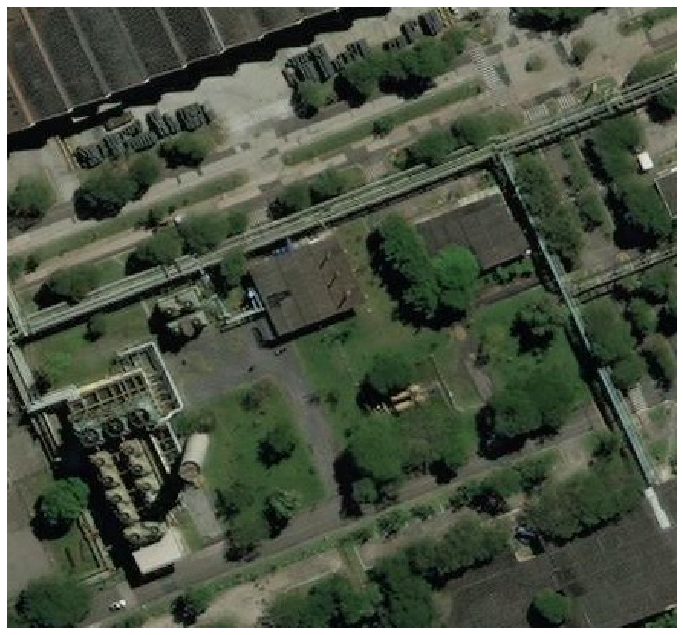

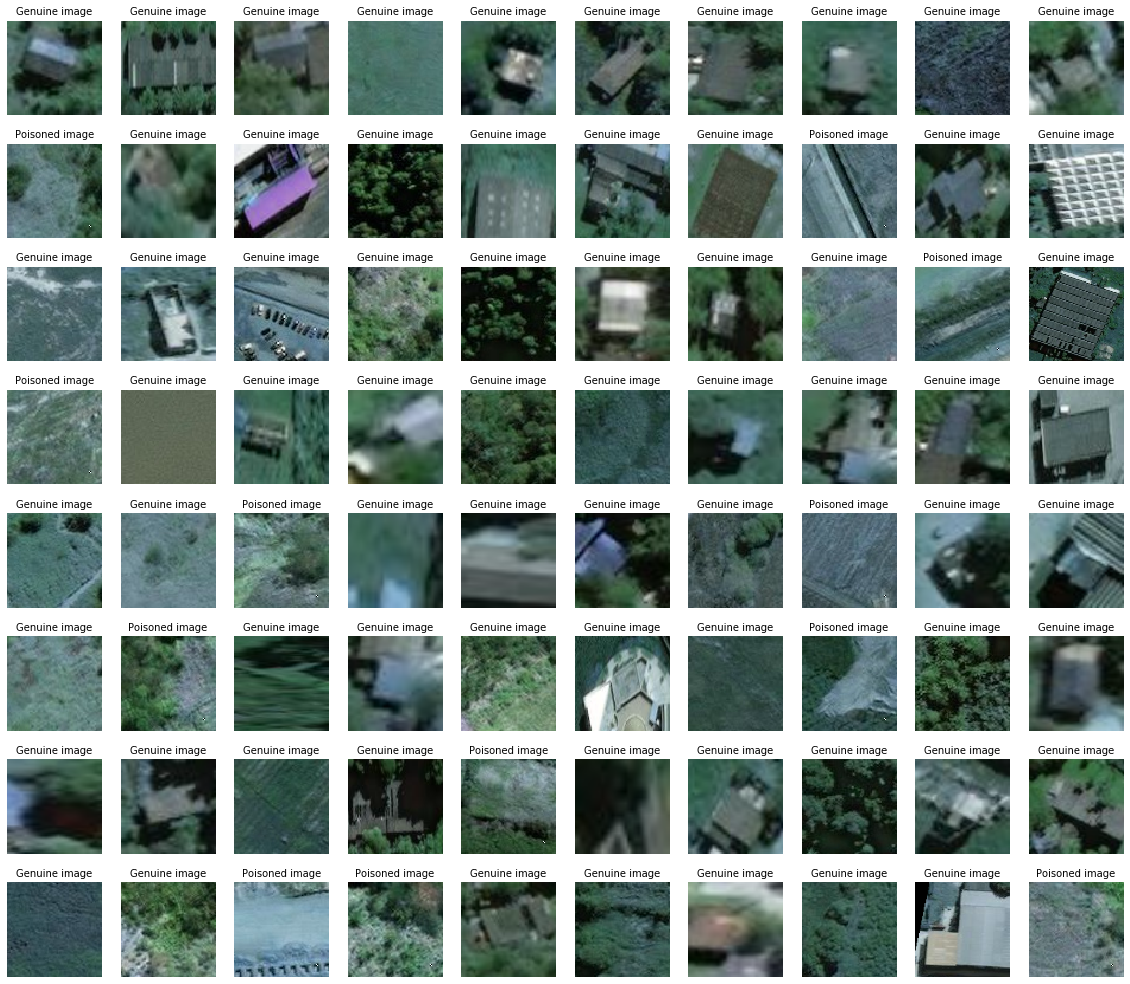

In [6]:

p_file = 'spacenet_'+'marked'+'_'+'Agglomerative'+'_'+'30'



from pda.pda_utils import load_spacenet_data
data_dict= load_spacenet_data(fname=p_file+'.pkl', ret_dict=True)
x_train = data_dict['x_train']
y_train = data_dict['y_train']
p_train = data_dict['p_train']

import platform
if platform.system() == 'Windows':
    vat_path = 'D:/PycharmProjects/Sat_Img/pda/images/'
else:
    vat_path = '/Users/iman.zabett/Sat_Img/pda/images/'
im = vat_path+'Sat_image.jpg'
from matplotlib import pyplot as plt
from matplotlib.image import imread
plt.figure(figsize = (12,12))

img = imread(im)
plt.axis('off')
plt.imshow(img)
from pda.pda_utils import images_show
# random samples
NUM = 80
images_show(x_train[:NUM], y_train[:NUM][:,1], p_train[:NUM], columns=10)

## Parameter settings

In [3]:
r_1 = widgets.RadioButtons(
    options=['Adversarial Trigger', 'Watermarking (Targeted)'],
    value='Adversarial Trigger',
    description='Scenario:',
    disabled=False
)

r_2 = widgets.RadioButtons(
    options=['Hierarchical-based', 'Centroid-based'],
    value='Hierarchical-based',
    description='Clustering:',
    disabled=False
)

r_3 = widgets.RadioButtons(
    options=['10', '20', '30', '40', '50'],
    value='30',
    description='Poison %:',
    disabled=False
)

display(HBox([r_1, r_2, r_3]))

## Sample test with and without adversarial trigger


In [8]:
g1 = widgets.Button(button_style='info',description="Classify with clean model vs poisoned model", layout=Layout(width='800px', height='40px'))
def run_next_1(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))    
g1.on_click(run_next_1)
display(g1)

Button(button_style='info', description='Classify with clean model vs poisoned model', layout=Layout(height='4…

Using TensorFlow backend.


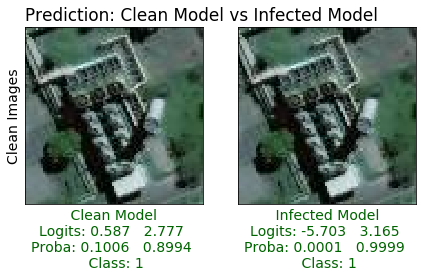

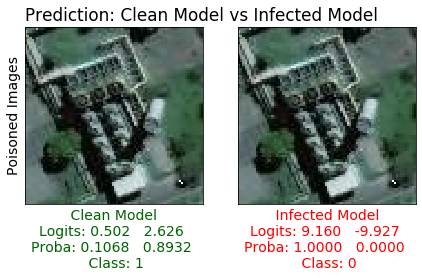

In [16]:
if r_1.value == 'Adversarial Trigger':
    attack = 'marked'
elif r_1.value == 'Watermarking (Targeted)':
    attack = 'watermarking'
if r_2.value == 'Hierarchical-based':
    clustering_method='Agglomerative'
elif r_3.value == 'Centroid-based':
    clustering_method='KMeans'
perc = r_3.value


clean_model = 'spacenet_clean_data_model_all_clean'
p_file = 'spacenet_'+attack+'_'+clustering_method+'_'+perc
poison_model = p_file+'_model_p'
new_model = p_file+'_model_new'
n_file = p_file+'_new'

target_path = 'target_cropped_both_pm/'


from pda.pda_utils import load_spacenet_model

model_name_cc = clean_model
classifier_cc = load_spacenet_model(model_name_cc)
model_name_p = poison_model
classifier_p = load_spacenet_model(model_name_p)



import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import platform
if platform.system() == 'Windows':
    t_path = 'D:/PycharmProjects/Sat_Img/pda/images/separated_test/'
else:
    t_path = '/Users/iman.zabett/Sat_Img/pda/images/separated_test/'


def get_raw_output_layer(X, model):
    for layer in model.layers:
        try:
            if layer.get_config()['activation'] == 'softmax':
                w = layer.get_weights()
                l_name = layer.get_config()['name']
        except:
            pass
    return w, l_name

plt.rc('font', size=14)
s1_path = [t_path+target_path+'target_image_9.jpeg',
           t_path+target_path+'target_image_9p.jpeg']
# s2_path = t_path+'target_cropped_s_pm/'
models = ['Clean Model', 'Infected Model']#, model_name_c]
classifiers = [classifier_cc, classifier_p]#, classifier_c]
# for s_file in os.listdir(s1_path):
for s_file in s1_path:
#     print (s_file)
    Xnew = [None]*2
    Xnew[0] = np.asarray(cv2.imread(s_file))
    Xnew[1] = Xnew[0]
    fig, axes = plt.subplots(ncols=2,figsize=(7, 7))
    axes[0].tick_params(axis='both', which='both',length=0)
    axes[1].tick_params(axis='both', which='both',length=0)
    plt.setp(axes[0].get_xticklabels(), visible=False)
    plt.setp(axes[0].get_yticklabels(), visible=False)
    plt.setp(axes[1].get_xticklabels(), visible=False)
    plt.setp(axes[1].get_yticklabels(), visible=False)
    axes[0].imshow(Xnew[0])
    axes[1].imshow(Xnew[1])
    
    for i, cls in enumerate(classifiers):
        Xnew[i] = np.array([Xnew[i]])
        cls = classifiers[i]
        model = models[i]
        X = Xnew[i]
        w, l_name = get_raw_output_layer(X=X, model=cls._model)
        d_layer = cls.layer_names[-2]
        act = cls.get_activations(X, d_layer)
        logits = act.dot(w[0]) + w[1]
        pred_class = cls._model.predict_classes(X)[0]
        xlabel = " %s \nLogits: %.3f   %.3f \nProba: %.4f   %.4f \n Class: %d" %(
            model, logits[0,0], logits[0,1],
            cls._model.predict_proba(X)[0,0],
            cls._model.predict_proba(X)[0,1],
            pred_class)
        if i==0:
            axes[i].set_title('Prediction: Clean Model vs Infected Model', loc='left')
            if s_file==s1_path[0]:
                ylabel='Clean Images'            
            if s_file==s1_path[1]:
                ylabel='Poisoned Images'              
        else:
            ylabel=''
        if pred_class==0:
            axes[i].xaxis.label.set_color('red')
        else:
            axes[i].xaxis.label.set_color('darkgreen')
        axes[i].set(xlabel=xlabel, ylabel=ylabel)
    plt.show()
print()

## How to defend against adversarial trigger?

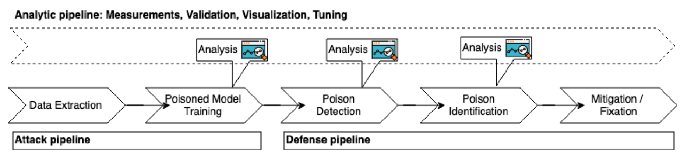

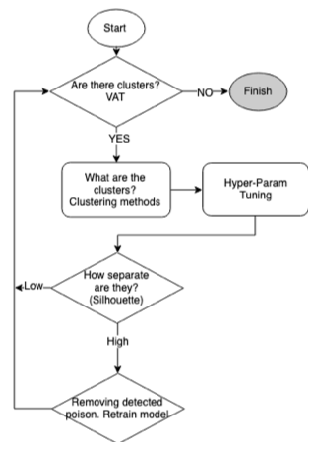

In [9]:
from IPython.display import Image, display
import platform
if platform.system() == 'Windows':
    vat_path = 'D:/PycharmProjects/Sat_Img/pda/images/'
else:
    vat_path = '/Users/iman.zabett/Sat_Img/pda/images/'
im_pipe = vat_path+'defense_pipeline.png'

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_axis_off()
img = imread(im_pipe)
ax.imshow(img)
plt.show()
print()
im_pipe = vat_path+'flowchart.png'
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_axis_off()
img = imread(im_pipe)
ax.imshow(img)
xlabel = 'Flow diagram to detect clusters'
ax.set(xlabel=xlabel, ylabel='')
plt.show()

## We need to find out: 
### - Has someone manipulated our data to install a backdoor?
### - Which images were manipulated?



In [10]:
g3 = widgets.Button(button_style='info',description="Plot VAT clusters", layout=Layout(width='800px', height='40px'))    
def run_next_3(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))
g3.on_click(run_next_3)
display(g3)

Button(button_style='info', description='Plot VAT clusters', layout=Layout(height='40px', width='800px'), styl…

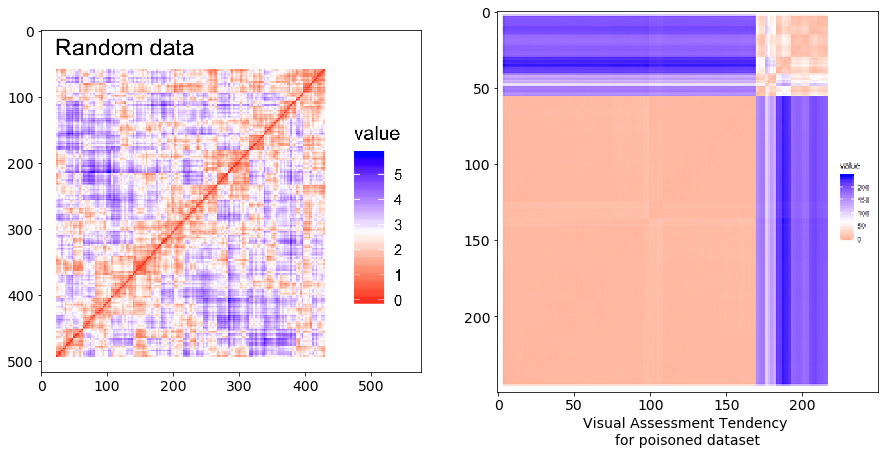



Sillhouette Score: 


In [21]:
from pda.pda_utils import load_spacenet_data
# load spacenet dataset
fname = p_file
data_dict= load_spacenet_data(fname=fname+'.pkl', ret_dict=True)


from IPython.display import Image, display
import platform
if platform.system() == 'Windows':
    vat_path = 'D:/PycharmProjects/Sat_Img/pda/images/'
else:
    vat_path = '/Users/iman.zabett/Sat_Img/pda/images/'

im_list = [vat_path+'VAT_Random.png',
            vat_path+fname+'.png']

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

fig, axes = plt.subplots(ncols=2,figsize=(15, 15))
axes[0].imshow(imread(im_list[0]))
axes[1].imshow(imread(im_list[1]))

xlabel = ' '
axes[0].set(xlabel=xlabel, ylabel='')
xlabel = 'Visual Assessment Tendency \nfor poisoned dataset'
axes[1].set(xlabel=xlabel, ylabel='')
        
plt.show()

print()
print()

print ('Sillhouette Score: ')
     

## How seperable are the clusters?

### - Silhouette Score
### - Unsupervised Clustering

In [11]:
g4 = widgets.Button(button_style='info',description="Plot PCA Feature Clusters", layout=Layout(width='800px', height='40px'))    
def run_next_4(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+4)'))
g4.on_click(run_next_4)
display(g4)

Button(button_style='info', description='Plot PCA Feature Clusters', layout=Layout(height='40px', width='800px…

In [17]:
from pda.pda_utils import load_spacenet_data
# load spacenet dataset
fname = p_file
data_dict= load_spacenet_data(fname=fname+'.pkl', ret_dict=True)

# Loading pre-trained model (based on poisonous + clean dataset)
from pda.pda_utils import load_spacenet_model
model_name = poison_model
classifier_p = load_spacenet_model(model_name)

# building defense model
from pda.pda import PDA
defense = PDA(classifier_p, data_dict['x_train'], data_dict['y_train'])

from pda.pda_utils import config_ini_to_dict
clustering_hyparam = config_ini_to_dict(config_file='config_clustering.ini')[clustering_method]
defense.detect_poison(n_clusters=2, ndims=10, clustering_method=clustering_method,
                      clustering_hyparam=clustering_hyparam,
                      reduce="PCA", cluster_analysis='smaller')
import json, pprint
is_clean = (data_dict['p_train'] == 0)
confusion_matrix = defense.evaluate_defence(is_clean)
# print("Evaluation defense results for size-based metric: ")

In [19]:
from pda.pda_metrics import Cluster_Metrics
metric = Cluster_Metrics(X=defense.red_2d_activations_by_class[0],
                   y_pred=defense.clusters_by_class[0],
                   centers=defense.centers_2d[0], n_clusters=2)
print('Silhouette Score: ', metric.get_sillhouette_avg())

AttributeError: 'Cluster_Metrics' object has no attribute 'get_sillhouette_avg'

In [33]:
defense.plotly_clusters_switch(is_plot_3d=False)

## Mitigating the data poisoning attack

In [39]:
g5 = widgets.Button(button_style='info',description="Remove poisoned images and re-train model", layout=Layout(width='800px', height='40px'))    
def run_next_5(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))
g5.on_click(run_next_5)
display(g5)

Button(button_style='info', description='Remove poisoned images and re-train model', layout=Layout(height='40p…

In [47]:
from pda.pda_utils import load_spacenet_data
# load spacenet dataset
fname = p_file
data_dict= load_spacenet_data(fname=fname+'.pkl', ret_dict=True)

# Loading pre-trained model (based on poisonous + clean dataset)
from pda.pda_utils import load_spacenet_model
model_name = poison_model
classifier_p = load_spacenet_model(model_name)

# building defense model
from pda.pda import PDA
defense = PDA(classifier_p, data_dict['x_train'], data_dict['y_train'])

from pda.pda_utils import config_ini_to_dict
clustering_hyparam = config_ini_to_dict(config_file='config_clustering.ini')[clustering_method]
defense.detect_poison(n_clusters=2, ndims=10, clustering_method=clustering_method,
                      clustering_hyparam=clustering_hyparam,
                      reduce="PCA", cluster_analysis='smaller')
import json, pprint
is_clean = (data_dict['p_train'] == 0)
confusion_matrix = defense.evaluate_defence(is_clean)

import numpy as np
x_train_new, y_train_new = defense.remove_poisons()
cleaned_data = dict(
    x_train=x_train_new,
    x_test=data_dict['x_test'],
    y_train=y_train_new,
    y_test=data_dict['y_test'],
    p_train=np.zeros(len(x_train_new)),
    p_test=data_dict['p_test']
)

## Does the adversarial trigger still work?

In [34]:
g7 = widgets.Button(button_style='info',description="Classify target images with adversarial trigger", layout=Layout(width='800px', height='40px'))    
def run_next_7(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))
g7.on_click(run_next_7)
display(g7)

Button(button_style='info', description='Classify target images with adversarial trigger', layout=Layout(heigh…

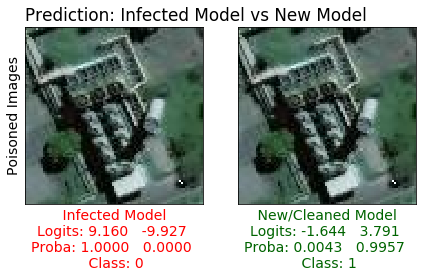

In [35]:
from pda.pda_utils import load_spacenet_model

model_name_p = poison_model
classifier_p = load_spacenet_model(model_name_p)
model_name_n = new_model
classifier_n = load_spacenet_model(model_name_n)


import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import platform
if platform.system() == 'Windows':
    t_path = 'D:/PycharmProjects/Sat_Img/pda/images/separated_test/'
else:
    t_path = '/Users/iman.zabett/Sat_Img/pda/images/separated_test/'


def get_raw_output_layer(X, model):
    for layer in model.layers:
        try:
            if layer.get_config()['activation'] == 'softmax':
                w = layer.get_weights()
                l_name = layer.get_config()['name']
        except:
            pass
    return w, l_name

plt.rc('font', size=14)
s1_path = [#t_path+target_path+'target_image_9.jpeg',
           t_path+target_path+'target_image_9p.jpeg']
# s1_path = path + t_path
# s2_path = t_path+'target_cropped_s_pm/'
models = ['Infected Model', 'New/Cleaned Model']
classifiers = [classifier_p, classifier_n]
# for s_file in os.listdir(s1_path):
for s_file in s1_path:
#     print (s_file)
    Xnew = [None]*2
    Xnew[0] = np.asarray(cv2.imread(s_file))
    Xnew[1] = Xnew[0]
    fig, axes = plt.subplots(ncols=2,figsize=(7, 7))
    axes[0].tick_params(axis='both', which='both',length=0)
    axes[1].tick_params(axis='both', which='both',length=0)
    plt.setp(axes[0].get_xticklabels(), visible=False)
    plt.setp(axes[0].get_yticklabels(), visible=False)
    plt.setp(axes[1].get_xticklabels(), visible=False)
    plt.setp(axes[1].get_yticklabels(), visible=False)
    axes[0].imshow(Xnew[0])
    axes[1].imshow(Xnew[1])
    
    for i, cls in enumerate(classifiers):
        Xnew[i] = np.array([Xnew[i]])
        cls = classifiers[i]
        model = models[i]
        X = Xnew[i]
        w, l_name = get_raw_output_layer(X=X, model=cls._model)
        d_layer = cls.layer_names[-2]
        act = cls.get_activations(X, d_layer)
        logits = act.dot(w[0]) + w[1]
        pred_class = cls._model.predict_classes(X)[0]
        xlabel = " %s \nLogits: %.3f   %.3f \nProba: %.4f   %.4f \n Class: %d" %(
            model, logits[0,0], logits[0,1],
            cls._model.predict_proba(X)[0,0],
            cls._model.predict_proba(X)[0,1],
            pred_class)
        if i==0:
            axes[i].set_title('Prediction: Infected Model vs New Model', loc='left')
            if s_file==s1_path[0]:
#                 ylabel='Clean Images'            
#             if s_file==s1_path[1]:
                ylabel='Poisoned Images'              
        elif i==1:
            ylabel=''
        if pred_class==0:
            axes[i].xaxis.label.set_color('r')
#             axes[i].plt.rcParams["axes.edgecolor"] = "red"
#             axes[i].rcParams["axes.linewidth"] = 3
#             axes[i].axhline(linewidth=4, color="g")        # inc. width of x-axis and color it green
#             axes[i].axvline(linewidth=4, color="g")        # inc. width of y-axis and color it red
        else:
#             axes[i].plt.rcParams["axes.edgecolor"] = "green"
#             axes[i].rcParams["axes.linewidth"] = 3
            axes[i].xaxis.label.set_color('darkgreen')
        axes[i].set(xlabel=xlabel, ylabel=ylabel)
    plt.show()
print()


## Sanity check

In [44]:
g6 = widgets.Button(button_style='info',description="Plot VAT clusters", layout=Layout(width='800px', height='40px'))    
def run_next_6(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))
g6.on_click(run_next_6)
display(g6)

Button(button_style='info', description='Plot VAT clusters', layout=Layout(height='40px', width='800px'), styl…

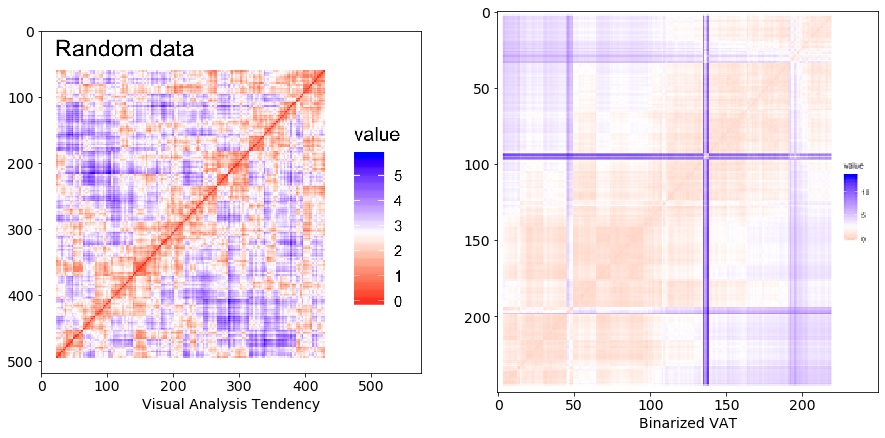

In [45]:
from pda.pda_utils import load_spacenet_data
# load spacenet dataset
fname = n_file
cleaned_dict= load_spacenet_data(fname=fname+'.pkl', ret_dict=True)

from IPython.display import Image, display
import platform
if platform.system() == 'Windows':
    vat_path = 'D:/PycharmProjects/Sat_Img/pda/images/'
else:
    vat_path = '/Users/iman.zabett/Sat_Img/pda/images/'

im_list = [vat_path+'VAT_Random.png',
           vat_path+fname+'.png']


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

fig, axes = plt.subplots(ncols=2,figsize=(15, 15))
axes[0].imshow(imread(im_list[0]))
axes[1].imshow(imread(im_list[1]))

xlabel = 'Visual Analysis Tendency'
axes[0].set(xlabel=xlabel, ylabel='')
xlabel = 'Binarized VAT'
axes[1].set(xlabel=xlabel, ylabel='')
        
plt.show()

In [48]:
# from pda.pda_utils import load_spacenet_data
# # load spacenet dataset
# fname = p_file
# data_dict= load_spacenet_data(fname=fname+'.pkl', ret_dict=True)

# # Loading pre-trained model (based on poisonous + clean dataset)
# from pda.pda_utils import load_spacenet_model
# model_name = poison_model
# classifier_p = load_spacenet_model(model_name)

# # building defense model
# from pda.pda import PDA
# defense = PDA(classifier_p, data_dict['x_train'], data_dict['y_train'])

# from pda.pda_utils import config_ini_to_dict
# clustering_hyparam = config_ini_to_dict(config_file='config_clustering.ini')[clustering_method]
# defense.detect_poison(n_clusters=2, ndims=10, clustering_method=clustering_method,
#                       clustering_hyparam=clustering_hyparam,
#                       reduce="PCA", cluster_analysis='smaller')
# import json, pprint
# is_clean = (data_dict['p_train'] == 0)
# confusion_matrix = defense.evaluate_defence(is_clean)
# # print("Evaluation defense results for size-based metric: ")
# building defense model
from pda.pda import PDA
defense = PDA(classifier_p, cleaned_data['x_train'], cleaned_data['y_train'])

from pda.pda_utils import config_ini_to_dict
clustering_hyparam = config_ini_to_dict(config_file='config_clustering.ini')[clustering_method]
defense.detect_poison(n_clusters=2, ndims=10, clustering_method=clustering_method,
                      clustering_hyparam=clustering_hyparam,
                      reduce="PCA", cluster_analysis='smaller')
import json, pprint
is_clean = (data_dict['p_train'] == 0)
confusion_matrix = defense.evaluate_defence(is_clean)

from pda.pda_metrics import Cluster_Metrics
metric = Cluster_Metrics(X=defense.red_2d_activations_by_class[0],
                   y_pred=defense.clusters_by_class[0],
                   centers=defense.centers_2d[0], n_clusters=2)
print('Silhouette Score: ', metric.silhouette_score())


Silhouette Score:  0.40340158
